Identify differentially accessible regions
================================

This tutorial assumes you have read the [Standard Pipeline](https://kzhang.org/SnapATAC2/tutorials/pbmc.html) tutorial and have finished preprocessing, clustering and cell annotations.

In [1]:
import snapatac2 as snap
import numpy as np
import polars as pl

snap.__version__

'2.1.0.1'

First let's load the previously processed h5ad file.

In [2]:
data = snap.read(str(snap.datasets.pbmc5k(type="annotated_h5ad")))
data

Updating file 'atac_pbmc_5k_annotated.h5ad' from 'http://renlab.sdsc.edu/kai/public_datasets/single_cell_atac/atac_pbmc_5k_annotated.h5ad' to '/home/kaizhang/.cache/snapatac2'.


AnnData object with n_obs x n_vars = 4363 x 6176550 backed at '/home/kaizhang/.cache/snapatac2/atac_pbmc_5k_annotated.h5ad'
    obs: Cell, tsse, n_fragment, frac_dup, frac_mito, doublet_score, is_doublet, leiden, cell_type
    var: Feature_ID, selected
    obsm: X_spectral, X_umap, insertion
    obsp: distances
    uns: leiden_colors, scrublet_threshold, cell_type_colors, reference_sequences, scrublet_sim_doublet_score, peaks, spectral_eigenvalue

/home/kaizhang/data/software/miniconda3/lib/python3.8/site-packages/polars/internals/frame.py:1675: UserWarning: setting a DataFrame by indexing is deprecated; Consider using DataFrame.with_column
  warnings.warn(


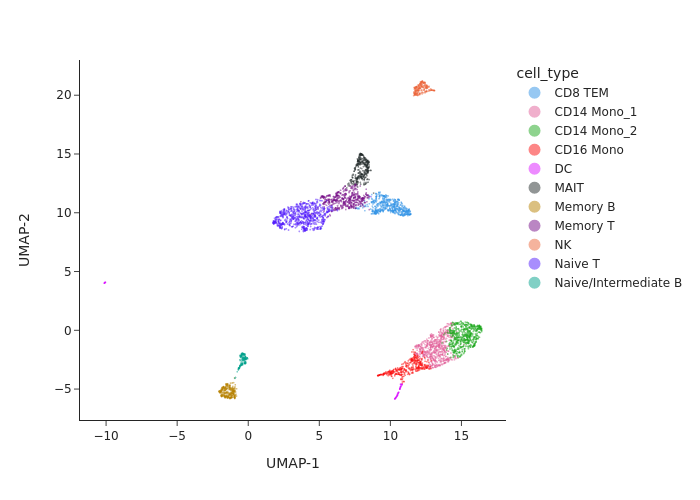

In [3]:
snap.pl.umap(data, color='cell_type', width=700, interactive=False)

Let's verify the peak by cell-type matrix is present in the AnnData object.

In [4]:
%%time
snap.tl.call_peaks(data, groupby='cell_type')

/home/kaizhang/data/software/miniconda3/lib/python3.8/site-packages/polars/internals/frame.py:1675: UserWarning:

setting a DataFrame by indexing is deprecated; Consider using DataFrame.with_column

preparing input...
calling peaks for 11 groups...
group Naive/Intermediate B: done!
group Memory B: done!
group NK: done!
group DC: done!
group MAIT: done!
group Memory T: done!
group CD8 TEM: done!
group Naive T: done!
group CD16 Mono: done!
group CD14 Mono_2: done!
group CD14 Mono_1: done!


CPU times: user 40.3 s, sys: 5.53 s, total: 45.8 s
Wall time: 2min 10s


We can now create the cell by peak matrix using `pp.make_peak_matrix`.

In [5]:
%%time
peak_mat = snap.pp.make_peak_matrix(data, file="peak_matrix.h5ad")
peak_mat

CPU times: user 1min 48s, sys: 1min 17s, total: 3min 6s
Wall time: 20.7 s


AnnData object with n_obs x n_vars = 4363 x 245289 backed at 'peak_matrix.h5ad'
    obs: Cell, tsse, n_fragment, frac_dup, frac_mito, doublet_score, is_doublet, leiden, cell_type
    var: Feature_ID

Finding marker regions
---------------------------

In this section, we are going to use a quick-and-dirty method to identify marker regions for each cell type. The `tl.marker_regions` function aggregates signal across cells and utilizes z-scores to identify specifically enriched peaks.

In [6]:
%%time
marker_peaks = snap.tl.marker_regions(peak_mat, groupby='cell_type', pvalue=0.01)

CPU times: user 7.89 s, sys: 698 ms, total: 8.59 s
Wall time: 8.56 s


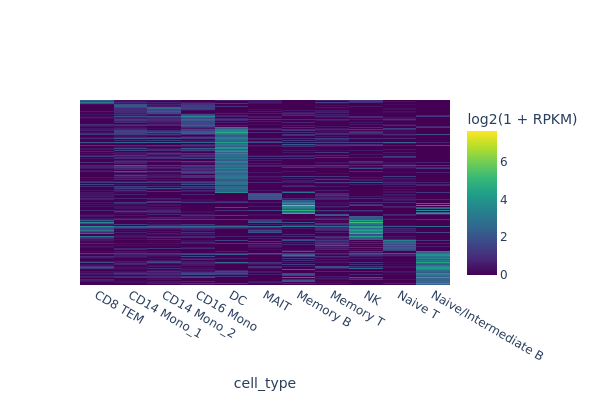

In [7]:
snap.pl.regions(peak_mat, groupby='cell_type', peaks=marker_peaks, interactive=False)

In [8]:
%%time
motifs = snap.tl.motif_enrichment(
    motifs=snap.datasets.cis_bp(unique=True),
    regions=marker_peaks,
    genome_fasta=snap.genome.hg38,
)

2022-09-28 06:50:54,074 >>> Fetching 47219 sequences ...
2022-09-28 06:53:58,435 >>> Computing enrichment ...
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1165/1165 [03:03<00:00,  6.35it/s]


CPU times: user 1h 29min 44s, sys: 25.3 s, total: 1h 30min 10s
Wall time: 6min 29s


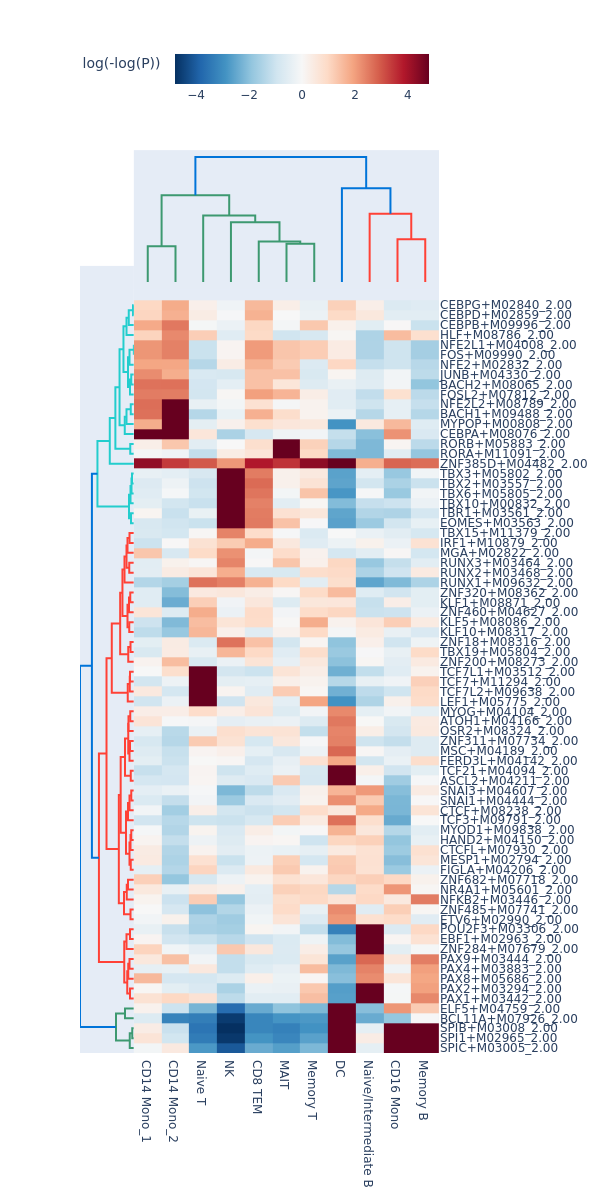

In [9]:
snap.pl.motif_enrichment(motifs, min_fdr=0.0001, height=1200, interactive=False)

## Regression-based differential test


The `tl.marker_regions` above does not consider the variations across cells. To fully utilize the single-cell information, we can apply regression-based differential test method. First, Let's select the peaks that are either present in naive B cells or memory B cells.

In [10]:
group1 = "Naive/Intermediate B"
group2 = "Memory B"
naive_B = data.obs['cell_type'] == group1
memory_B = data.obs['cell_type'] == group2
peaks_selected = np.logical_or(
    data.uns["peaks"][group1].to_numpy(),
    data.uns["peaks"][group2].to_numpy(),
)

Perform differential test using `tl.diff_test`.

In [11]:
%%time
diff_peaks = snap.tl.diff_test(
    peak_mat,
    cell_group1=naive_B,
    cell_group2=memory_B,
    features=peaks_selected,
)

Input contains 102779 features, now perform filtering ...
Testing 31451 features ...
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31451/31451 [03:57<00:00, 132.30it/s]


CPU times: user 4min 6s, sys: 4.78 s, total: 4min 11s
Wall time: 4min 10s


Filter the results based on adjusted p-value or FDR.

In [12]:
diff_peaks = diff_peaks.filter(pl.col('adjusted p-value') < 0.01)
diff_peaks.head()

feature name,log2(fold_change),p-value,adjusted p-value
str,f64,f64,f64
"""chr17:3558485-3558986""",6.293982,1.0312e-28,3.2431e-24
"""chr5:156402577-156403078""",4.642244,3.1412e-25,4.9397e-21
"""chr1:159076682-159077183""",4.681643,2.2184e-21,2.3257e-17
"""chr6:52497605-52498106""",5.412377,6.2204e-21,4.8909e-17
"""chr1:15949529-15950030""",4.812347,6.6527e-20,4.1847e-16


/home/kaizhang/data/software/miniconda3/lib/python3.8/site-packages/polars/internals/frame.py:1675: UserWarning:

setting a DataFrame by indexing is deprecated; Consider using DataFrame.with_column



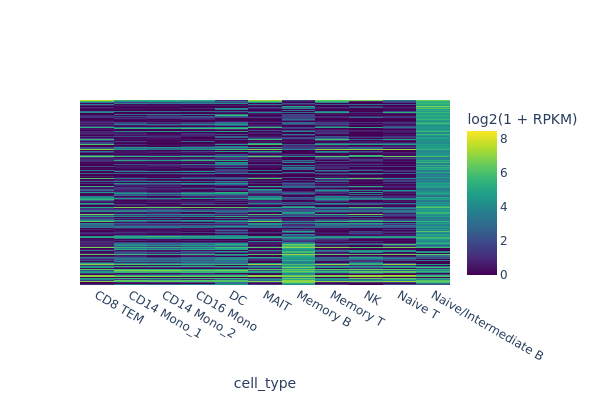

In [13]:
snap.pl.regions(
    peak_mat,
    groupby = 'cell_type',
    peaks = {
        group1: diff_peaks.filter(pl.col("log2(fold_change)") > 0)['feature name'].to_numpy(),
        group2: diff_peaks.filter(pl.col("log2(fold_change)") < 0)['feature name'].to_numpy(),
    },
    interactive = False,
)

In the next example we are going to identify peaks that are accessible in memory B cells but not in the rest of cells. One way of doing this is to select random cells from each cluster to form the background, and then perform test between memory B cells and the background.

Here we randomly select 50 cells from other cell clusters, and set the `direction = "positive"` because we are interested in peaks that are more accessible in memory B cells.

In [14]:
barcodes = np.array(data.obs_names)
background = []
for i in np.unique(data.obs['leiden']):
    if i != group2:
        cells = np.random.choice(
            barcodes[data.obs['leiden'] == i],
            size = 50,
            replace = False,
        )
        background.append(cells)
background = np.concatenate(background)

In [15]:
diff_peaks = snap.tl.diff_test(
    peak_mat,
    cell_group1 = memory_B,
    cell_group2 = background,
    features = data.uns["peaks"][group2].to_numpy(),
    direction = "positive",
)

Input contains 81336 features, now perform filtering ...
Testing 18121 features ...
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18121/18121 [02:32<00:00, 118.46it/s]


In [16]:
diff_peaks = diff_peaks.filter(pl.col('adjusted p-value') < 0.01)
diff_peaks.head()

feature name,log2(fold_change),p-value,adjusted p-value
str,f64,f64,f64
"""chr14:105817874-105818375""",3.0534,1.4180e-44,2.5695e-40
"""chr11:95715785-95716286""",3.088415,9.7560e-44,8.8394e-40
"""chr11:60455455-60455956""",2.622945,1.1470e-39,6.9285e-36
"""chr9:37409051-37409552""",2.519909,2.8604e-38,1.2958e-34
"""chr6:167112879-167113380""",3.105207,1.2476e-36,4.5216e-33


/home/kaizhang/data/software/miniconda3/lib/python3.8/site-packages/polars/internals/frame.py:1675: UserWarning:

setting a DataFrame by indexing is deprecated; Consider using DataFrame.with_column



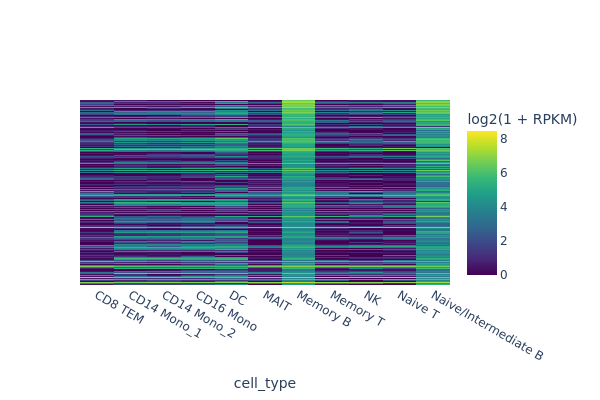

In [17]:
snap.pl.regions(
    peak_mat,
    groupby = 'cell_type',
    peaks = {
        group2: diff_peaks['feature name'].to_numpy(),
    },
    interactive = False,
)

## To Be Continued ...